In [60]:
def function1(input1):
    return input1 * "from first function"

In [61]:
def function2(input2):
    return input2 * "from second function"

In [62]:
# %pip install langgraph

In [63]:
from langgraph.graph import StateGraph

In [64]:

class MyState(dict): pass

from langgraph.graph import StateGraph
workflow = StateGraph(MyState)


In [65]:
workflow.add_node("function1", function1)


In [66]:
workflow.add_node("function2", function2)


In [67]:
workflow.set_entry_point("function1")

In [68]:
workflow.set_finish_point("function2")

In [69]:
app1=workflow.compile()


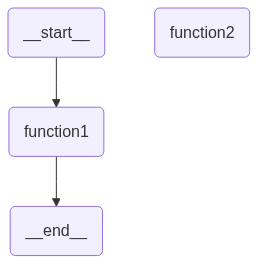

In [70]:
from IPython.display import Image, display

try:
    display(Image(app1.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [71]:
# for output in app1.stream(input):
#     for key,value in output.items():
#         print(f"here is output from {key}")
#         print("_______")
#         print(value)
#         print("\n")


In [72]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")

In [73]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [74]:
llm.invoke("hi").content


'Hello! How can I help you today?'

In [75]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [76]:
docs = """
Cricket is a bat-and-ball game that is played between two teams of eleven players on a field, at the centre of which is a 22-yard (20-metre; 66-foot) pitch with a wicket at each end, each comprising two bails (small sticks) balanced on three stumps. Two players from the batting team, the striker and nonstriker, stand in front of either wicket holding bats, while one player from the fielding team, the bowler, bowls the ball toward the striker's wicket from the opposite end of the pitch. The striker's goal is to hit the bowled ball with the bat and then switch places with the nonstriker, with the batting team scoring one run for each of these swaps. Runs are also scored when the ball reaches the boundary of the field or when the ball is bowled illegally.

The fielding team aims to prevent runs by dismissing batters (so they are "out"). Dismissal can occur in various ways, including being bowled (when the ball hits the striker's wicket and dislodges the bails), and by the fielding side either catching the ball after it is hit by the bat but before it hits the ground, or hitting a wicket with the ball before a batter can cross the crease line in front of the wicket. When ten batters have been dismissed, the innings (playing phase) ends and the teams swap roles. Forms of cricket range from traditional Test matches played over five days to the newer Twenty20 format (also known as T20), in which each team bats for a single innings of 20 overs (each "over" being a set of 6 fair opportunities for the batting team to score) and the game generally lasts three to four hours.

Traditionally, cricketers play in all-white kit, but in limited overs cricket, they wear club or team colours. In addition to the basic kit, some players wear protective gear to prevent injury caused by the ball, which is a hard, solid spheroid made of compressed leather with a slightly raised sewn seam enclosing a cork core layered with tightly wound string.

The earliest known definite reference to cricket is to it being played in South East England in the mid-16th century. It spread globally with the expansion of the British Empire, with the first international matches in the second half of the 19th century. The game's governing body is the International Cricket Council (ICC), which has over 100 members, twelve of which are full members who play Test matches. The game's rules, the Laws of Cricket, are maintained by Marylebone Cricket Club (MCC) in London. The sport is followed primarily in South Asia, Australia, New Zealand, the United Kingdom, Southern Africa, and the West Indies.[2]

While traditionally, cricket has largely been played by men, Women's cricket has experienced large growth in the 21st century.[3]

The most successful side playing international cricket is Australia, which has won eight One Day International trophies, including six World Cups, more than any other country, and has been the top-rated Test side more than any other country.[4][
"""

In [77]:
loader=DirectoryLoader("../langgraph_from_scratch/data", glob="./*.txt",loader_cls=TextLoader)
docs=loader.load()
text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=100,
    chunk_overlap=50
)
new_docs = text_splitter.split_documents(documents=docs)
doc_strings = [doc.page_content for doc in new_docs]

In [78]:
# %pip install chromadb

In [79]:
db = Chroma.from_documents(new_docs, embeddings)

retriever = db.as_retriever(search_kwargs={"k": 3})

In [80]:
query = "what is cricket"
docs = retriever.get_relevant_documents(query)
print(docs[0].metadata)
print(docs[0].page_content)

for doc in docs:
    print(doc)

{'source': '..\\langgraph_from_scratch\\data\\llama3.txt'}
Cricket is a bat-and-ball game that is played between two teams of eleven players on a field, at the
page_content='Cricket is a bat-and-ball game that is played between two teams of eleven players on a field, at the' metadata={'source': '..\\langgraph_from_scratch\\data\\llama3.txt'}
page_content='Cricket is a bat-and-ball game that is played between two teams of eleven players on a field, at the' metadata={'source': '..\\langgraph_from_scratch\\data\\llama3.txt'}
page_content='Cricket is a bat-and-ball game that is played between two teams of eleven players on a field, at the' metadata={'source': '..\\langgraph_from_scratch\\data\\llama3.txt'}


In [81]:
def function_1(AgentState):
    
    message=AgentState["messages"]
    
    question=message[-1]
    
    complete_prompt="Your task is to provide only the brief answer based on the user query. \
        Don't include too much reasoning. Following is the user query: " + question
    
    response = llm.invoke(complete_prompt)
    
    AgentState['messages'].append(response.content) # appending LLM call response to the AgentState
    
    #print(AgentState)
    
    return AgentState

In [82]:
AgentState={}


In [83]:
AgentState["messages"]=[]


In [84]:
AgentState


{'messages': []}

In [85]:
AgentState["messages"].append("hi, how are you?")


In [86]:
AgentState


{'messages': ['hi, how are you?']}

In [87]:
AgentState["messages"].append("hi, what you doing?")


In [88]:
AgentState


{'messages': ['hi, how are you?', 'hi, what you doing?']}

In [89]:
def function_2(AgentState):
    messages = AgentState['messages']
    question = messages[0] ## Fetching the user question

    template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    retrieval_chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | llm
        | StrOutputParser()
        )
    result = retrieval_chain.invoke(question)
    return result

In [90]:
# Define a Langchain graph

class MyState(dict): pass

from langgraph.graph import StateGraph
workflow4 = StateGraph(MyState)
workflow4.add_node("LLM", function_1)
workflow4.add_node("RAGtool", function_2)
workflow4.add_edge('LLM', 'RAGtool')
workflow4.set_entry_point("LLM")
workflow4.set_finish_point("RAGtool")
app4 = workflow4.compile()

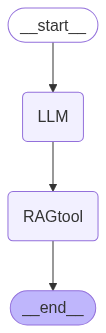

In [91]:
from IPython.display import Image, display

try:
    display(Image(app4.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [92]:
inputs = {"messages": ["Tell me about cricket"]}


In [94]:
inputs

{'messages': ['Tell me about cricket']}

In [96]:
# for output in app4.stream(inputs):
#     # stream() yields dictionaries with output keyed by node name
#     for key, value in output.items():
#         print(f"Output from node '{key}':")
#         print("---")
#         print(value)
#     print("\n---\n")

### conditional wrokflow
 :-> using Router Function

In [ ]:
# from langgraph.graph import StateGraph,END

# workflow5 = StateGraph(AgentState) ### StateGraph with AgentState


# workflow5.add_node("agent", function_1)

# workflow5.add_node("RAG", function_2)

# workflow5.add_node("LLM", function_3)


# workflow5.set_entry_point("agent")

# workflow5.add_conditional_edges(
#     "agent",
    
    
#     router,
#     {
#         "RAG Call": "RAG",
#         "LLM Call": "LLM",
#     }
# )

# workflow5.add_edge("RAG",END)


# workflow5.add_edge("LLM",END)


# app5=workflow5.compile()